In [37]:
from src.ocsmm.OneClassSMMClassifier import OneClassSMMClassifier
import numpy as np
from torch import FloatTensor
import matplotlib.pyplot as plt
import torch
import pandas as pd

have a 2d gaussian distribution with 0 mean and I covariance matrix. 
add a 3rd feature whos value is (1,2,3) if normal and (18, 91, 20) if outlier.

In [38]:
np.random.seed(20)

# Parameters
num_groups = 30
num_points_per_group = 30
num_features = 3  # Two Gaussian features + one label
num_normal = 27
num_anomalous = 3

# Generate data
dataset = []
for i in range(num_groups):
    if i < num_normal:
        label = np.random.choice([1, 2, 3])  
    else:
        label = np.random.choice([18, 19, 20]) 
    points = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]], size=num_points_per_group)
    feature_3 = np.full((num_points_per_group, 1), label)  # Feature 3 as a column
    group_data = np.hstack([points, feature_3]) 
    dataset.append(group_data)

# Convert dataset into a 3D NumPy array
final_dataset = np.array(dataset)  

In [39]:
final_dataset

array([[[-9.50443117e-01,  1.50227571e+00,  3.00000000e+00],
        [ 2.12601055e+00,  2.49155430e-01,  3.00000000e+00],
        [-6.20642157e-01, -8.34532935e-01,  3.00000000e+00],
        ...,
        [-2.21909547e+00, -7.49404606e-01,  3.00000000e+00],
        [ 4.86063175e-01, -1.76752659e+00,  3.00000000e+00],
        [ 2.22710846e-01, -7.05439508e-01,  3.00000000e+00]],

       [[-5.48331454e-01,  2.97280923e-01,  3.00000000e+00],
        [-6.00914445e-01,  9.10865062e-01,  3.00000000e+00],
        [ 1.43127170e+00,  2.60349438e-01,  3.00000000e+00],
        ...,
        [ 6.83495390e-01,  9.26002960e-01,  3.00000000e+00],
        [ 2.27227061e-01, -1.96859016e-01,  3.00000000e+00],
        [-6.39854207e-01, -1.33643179e-02,  3.00000000e+00]],

       [[-3.14030161e-01, -9.55774320e-01,  1.00000000e+00],
        [ 4.41255095e-01, -2.07323620e-02,  1.00000000e+00],
        [ 4.15292839e-01, -6.92940082e-02,  1.00000000e+00],
        ...,
        [-8.67849560e-01,  5.16497796e-01,

In [40]:
classifier = OneClassSMMClassifier(nu=0.1)

In [41]:
classifier.fit(final_dataset)

In [42]:
decision, y_pred = classifier.predict(final_dataset)

In [43]:
count_neg_1 = np.count_nonzero(y_pred == -1)
count_pos_1 = np.count_nonzero(y_pred == 1)

print(f"Count of -1: {count_neg_1}")
print(f"Count of +1: {count_pos_1}")

Count of -1: 3
Count of +1: 27


In [44]:
decision

array([ 0.03426532,  0.04315777,  0.03342603,  0.03631718,  0.03468904,
        0.03426581,  0.03160084,  0.0342653 ,  0.03195794,  0.04020045,
        0.09355575,  0.03703902,  0.09439567,  0.03426599,  0.03426522,
        0.03838306,  0.0302475 ,  0.09474867,  0.03872608,  0.04380844,
        0.04065058,  0.08410527,  0.08826389,  0.0367205 ,  0.02895426,
        0.03426597,  0.03471417, -0.1104126 , -0.11249544, -0.1389472 ])

In [35]:
outlier_indices = [i for i, value in enumerate(y_pred) if value == -1]
outlier_indices

[28, 29]

In [36]:
from src.explanation_algorithms.OCSMMSHAP import OCSMMSHAP
ocsmm_shap = OCSMMSHAP(X=final_dataset, classifier=classifier, decision=decision)
ocsmm_shap.fit_ocsmmshap(X=final_dataset, num_coalitions=2**final_dataset[0].shape[1])

c:\Users\swath\Documents\CISPA\OCSVM-SHAP\src\utils\shapley_procedure\coalitions.py:18: RuntimeWarning: divide by zero encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
c:\Users\swath\Documents\CISPA\OCSVM-SHAP\src\utils\shapley_procedure\coalitions.py:18: RuntimeWarning: invalid value encountered in cast
  set_to_1 = np.floor(np.log2(rest)).astype(int)
c:\Users\swath\Documents\CISPA\OCSVM-SHAP\src\utils\shapley_procedure\coalitions.py:18: RuntimeWarning: invalid value encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
100%|██████████| 7/7 [00:00<00:00, 57.42it/s]


In [11]:
shapley_values = ocsmm_shap.return_deterministic_shapley_values()

The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)


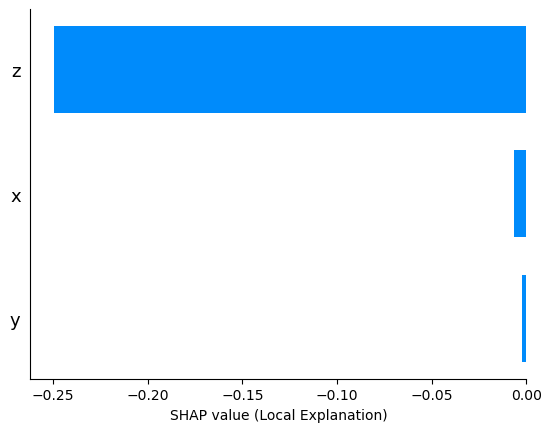

In [13]:
from src.utils.visualisation.deterministic_values import global_bar_plot, bar_plot
bar_plot(shapley_values.T[28], feature_names=['x', 'y', 'z'])

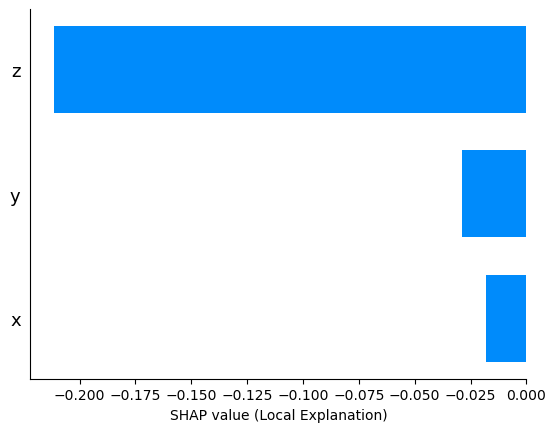

In [14]:
bar_plot(shapley_values.T[29], feature_names=['x', 'y', 'z'])

Feature z has the highest value in both the outliers which is the expected behaviour

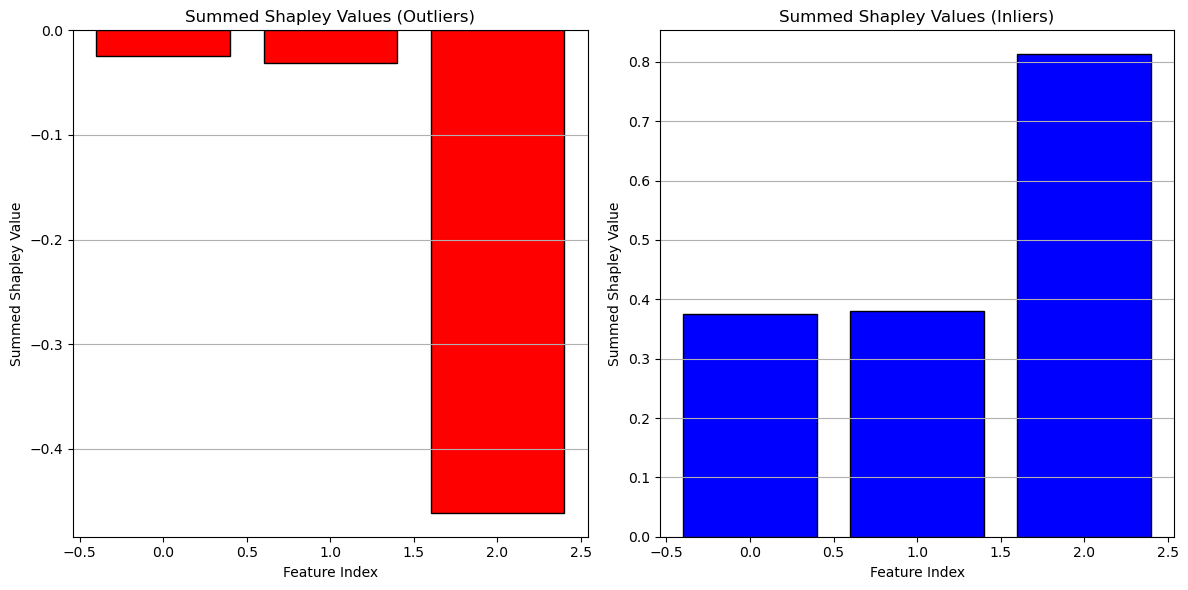

In [15]:
inlier_indices = [i for i in range(shapley_values.shape[1]) if i not in outlier_indices]

summed_outlier_shapley = shapley_values[:, outlier_indices].sum(dim=1).numpy()
summed_inlier_shapley = shapley_values[:, inlier_indices].sum(dim=1).numpy()

# Plot histogram
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Outlier Shapley Values
ax[0].bar(range(len(summed_outlier_shapley)), summed_outlier_shapley, color='red', edgecolor='black')
ax[0].set_title('Summed Shapley Values (Outliers)')
ax[0].set_xlabel('Feature Index')
ax[0].set_ylabel('Summed Shapley Value')
ax[0].grid(True, axis='y')

# Inlier Shapley Values
ax[1].bar(range(len(summed_inlier_shapley)), summed_inlier_shapley, color='blue', edgecolor='black')
ax[1].set_title('Summed Shapley Values (Inliers)')
ax[1].set_xlabel('Feature Index')
ax[1].set_ylabel('Summed Shapley Value')
ax[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

Even in the case of inliers, feature z is telling us the reasons for the prediction

The most influential feature is the feature 3, which is causing the outlier prediction

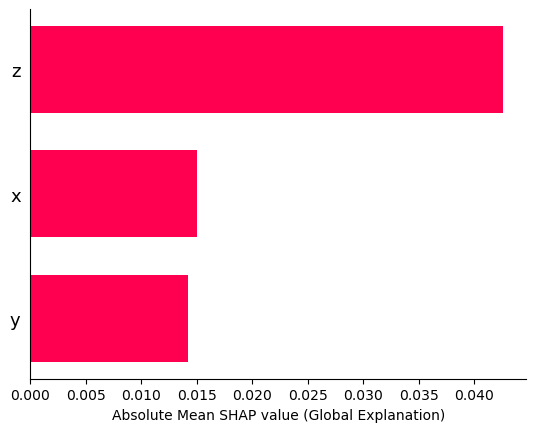

In [16]:
# global importance measure
mean_abs_shap_values = np.abs(shapley_values.T).mean(axis=0)  

# Call bar_plot for global explanation
global_bar_plot(mean_abs_shap_values, feature_names=['x', 'y', 'z'])

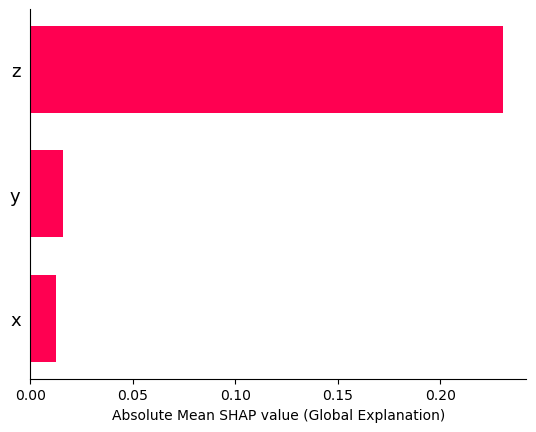

In [20]:
selected_shap_values = shapley_values[:,outlier_indices]
mean_abs_shap_values_outlier = np.abs(selected_shap_values).mean(axis=1) 
global_bar_plot(mean_abs_shap_values_outlier, feature_names=['x', 'y', 'z'])